## NREL WIND Toolkit - HSDS Demo

This notebook demonstrates basic usage of the National Renewable Energy Laboratory (NREL) Wind Integration National Dataset (WIND) Toolkit data. The data is provided from Amazon Web Services using the HDF Group's Highly Scalable Data Service (HSDS).

For this to work you must first install h5pyd:

```
pip install --user h5pyd
```

Next you'll need to configure HSDS:

```
hsconfigure
```

and enter at the prompt:

```
hs_endpoint = https://developer.nrel.gov/api/hsds
hs_username = None
hs_password = None
hs_api_key = 3K3JQbjZmWctY0xmIfSYvYgtIcM3CN0cb1Y2w9bf
```

*The example API key here is for demonstation and is rate-limited per IP. To get your own API key, visit https://developer.nrel.gov/signup/*

You can also add the above contents to a configuration file at ~/.hscfg

In [2]:
%matplotlib inline
import h5pyd
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from pyproj import Proj
import dateutil
import utils

## Basic Usage

In [3]:
# Open the wind data "file"
# server endpoint, username, password is found via a config file
f = h5pyd.File("/nrel/wtk-us.h5", 'r')  

In [4]:
list(f.attrs)  # list attributes belonging to the root group

['history']

In [5]:
f.attrs['history']   # attributes can be used to provide desriptions of the content

'Produced by 3TIER, Inc. under NREL subcontract AGV-2-22460-01'

## Datasets

In [6]:
list(f)  # list the datasets in the file

['inversemoninobukhovlength_2m',
 'status',
 'windspeed_10m',
 'temperature_80m',
 'temperature_160m',
 'temperature_200m',
 'pressure_200m',
 'DIF',
 'temperature_10m',
 'winddirection_120m',
 'windspeed_120m',
 'windspeed_140m',
 'temperature_60m',
 'relativehumidity_2m',
 'windspeed_200m',
 'temperature_140m',
 'precipitationrate_0m',
 'winddirection_160m',
 'pressure_0m',
 'GHI',
 'windspeed_80m',
 'winddirection_100m',
 'temperature_2m',
 'temperature_40m',
 'coordinates',
 'winddirection_60m',
 'windspeed_160m',
 'winddirection_40m',
 'winddirection_10m',
 'DNI',
 'winddirection_200m',
 'windspeed_60m',
 'datetime',
 'pressure_100m',
 'windspeed_40m',
 'temperature_120m',
 'windspeed_100m',
 'winddirection_140m',
 'temperature_100m',
 'winddirection_80m']

In [7]:
dset = f['windspeed_100m']
dset.shape

(61368, 1602, 2976)

In [8]:
dset2 = f['winddirection_100m']
dset2.shape

(61368, 1602, 2976)

In [9]:
dset.dtype

dtype('float32')

In [10]:
dset.shape[0] * dset.shape[1] * dset.shape[2] * 4 * 10**-12  # aprox 1 TB per dataset!

1.170300524544

In [11]:
dset.chunks

(24, 89, 186)

In [12]:
dset.chunks[0] * dset.chunks[1] * dset.chunks[2] * 4 * 10**-6 # aprox 1.5 MB per chunk

1.589184

## Time-slicing

Get the datetime index from the server and convert to a pandas dataframe for convenience:

In [13]:
dt = f["datetime"]
dt = pd.DataFrame({"datetime": dt[:]},index=range(0,dt.shape[0]))
dt['datetime'] = dt['datetime'].apply(dateutil.parser.parse)
dt.head()

,datetime
0,2007-01-01 00:00:00
1,2007-01-01 01:00:00
2,2007-01-01 02:00:00
3,2007-01-01 03:00:00
4,2007-01-01 04:00:00


Extract indexes for a particular span of time:

In [14]:
twentyten = dt.loc[(dt.datetime >= '2010-01-01') & (dt.datetime < '2011-01-01')].index
twentyten

Int64Index([26304, 26305, 26306, 26307, 26308, 26309, 26310, 26311, 26312,
            26313,
            ...
            35054, 35055, 35056, 35057, 35058, 35059, 35060, 35061, 35062,
            35063],
           dtype='int64', length=8760)

Or a particular date:

In [15]:
timestep = dt.loc[dt.datetime == '2012-04-01 12:00:00'].index[0]
timestep

46020

## Map Data

In [43]:
%time data = dset[timestep,::8,::8]   # extract every 8th record at a particular time

Wall time: 3.1 s


In [45]:
data.shape

(201, 372)

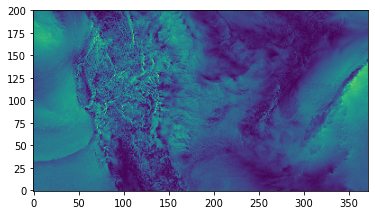

In [44]:
plt.imshow(data, origin="lower")

In [17]:
data

array([[10.889008 , 10.440384 , 10.602127 , ...,  7.0802917,  7.2450943,
         7.4129486],
       [10.086365 , 10.406815 , 10.78524  , ...,  7.867668 ,  7.5655365,
         7.669304 ],
       [10.51973  ,  8.78933  , 10.846275 , ...,  7.4495697,  7.7852707,
         7.9195557],
       ...,
       [11.743523 , 11.893066 , 12.524796 , ..., 10.049744 ,  9.74456  ,
         9.732353 ],
       [11.926636 , 12.298958 , 12.54921  , ..., 10.049744 ,  9.945984 ,
        10.129097 ],
       [12.143318 , 12.317268 , 12.555313 , ...,  9.881897 ,  9.616379 ,
         9.6072235]], dtype=float32)

In [18]:
data2 = dset2[timestep, ::8,::8]

In [19]:
data.shape

(201, 372)

In [20]:
wind_data = np.dstack([data[:200,:200], data2[:200,:200]])
wind_data.shape

(200, 200, 2)

In [21]:
ua = np.multiply(data[:200,:200], np.cos(np.radians(data2[:200,:200]+np.pi/2)))
va = np.multiply(data[:200,:200], np.sin(np.radians(data2[:200,:200]+np.pi/2)))

In [22]:
ua.shape

(200, 200)

In [23]:
wind_data = np.dstack([ua,va])

In [24]:
wind_data.shape

(200, 200, 2)

In [39]:
# wind = np.reshape(wind_data, (4, 100, 100, 2))
wind[0] = wind_data[:100, :100, :]
wind[1] = wind_data[100:200, :100, :]
wind[2] = wind_data[:100, 100:200, :]
wind[3] = wind_data[100:200, 100:200, :]
wind.shape

(4, 100, 100, 2)

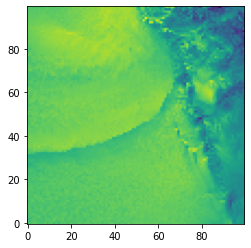

In [41]:
data = wind[0,:,:,0]
plt.imshow(data, origin="lower")

In [26]:
wind

array([[[[  9.445892  ,   5.417159  ],
         [  9.019143  ,   5.2589617 ],
         [  9.497299  ,   4.7123675 ],
         ...,
         [  2.7740743 ,   0.96120614],
         [  1.9424363 ,   0.85948133],
         [ -1.069263  ,   0.7395289 ]],

        [[ -1.8353208 ,   1.5540129 ],
         [ -2.405567  ,   0.6558232 ],
         [ -2.4320755 ,   0.03499221],
         ...,
         [ -4.2016964 ,   5.991977  ],
         [ -4.5751023 ,   6.3480844 ],
         [ -4.767175  ,   6.480037  ]],

        [[  8.036371  ,   6.095202  ],
         [  8.799633  ,   5.555919  ],
         [  9.747933  ,   4.6151056 ],
         ...,
         [  2.819611  ,   0.7255632 ],
         [  2.7001677 ,  -0.51965594],
         [  0.04241088,   0.48032427]],

        ...,

        [[ -1.2067564 ,  -4.3145328 ],
         [ -3.2280679 ,   0.53182423],
         [ -0.96541804,  -4.9918833 ],
         ...,
         [ -4.163143  ,   0.14816761],
         [ -6.0957346 ,  -0.6582504 ],
         [ -4.7018795 ,  -0

In [27]:
np.size(wind[1,:,:,:])

20000

In [28]:
data2[:10,:10]

array([[28.263199, 28.675186, 24.818878, 24.428848, 24.307999, 31.6306  ,
        27.790771, 24.297012, 24.368423, 25.75824 ],
       [35.607773, 30.696732, 23.76416 , 26.203186, 30.444046, 28.175293,
        28.757599, 23.86853 , 23.154388, 25.626389],
       [36.27797 , 35.217743, 30.11444 , 26.714066, 28.482925, 26.466873,
        27.477646, 27.900635, 25.939514, 21.363571],
       [31.789917, 29.51567 , 26.148254, 28.94986 , 27.235931, 21.226227,
        31.24057 , 29.850769, 27.521591, 24.846344],
       [36.602066, 33.377487, 26.367996, 15.249496, 28.94986 , 26.576736,
        30.158386, 20.973541, 30.11444 , 30.713211],
       [28.922394, 32.76773 , 31.663559, 29.098175, 34.723343, 28.598282,
        31.570175, 20.193481, 28.653214, 21.30864 ],
       [30.455032, 25.631882, 31.976685, 22.198547, 26.648148, 29.702438,
        28.24672 , 27.697372, 33.1138  , 19.693588],
       [31.306503, 26.862396, 29.169586, 25.373703, 27.895142, 32.125   ,
        30.16388 , 29.268478, 35.8659

In [29]:
wind.shape

(4, 100, 100, 2)

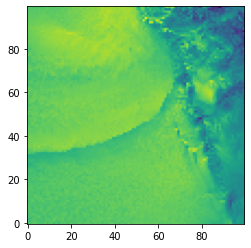

In [34]:
data = wind[0,:,:,0]
plt.imshow(data, origin="lower")

In [36]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import pandas as pd

def conv_layer_2d(x, filter_shape, stride, trainable=True):
    W = tf.get_variable(
        name='weight',
        shape=filter_shape,
        dtype=tf.float32,
        initializer=tf.contrib.layers.xavier_initializer(),
        trainable=trainable)
    b = tf.get_variable(
        name='bias',
        shape=[filter_shape[-1]],
        dtype=tf.float32,
        initializer=tf.contrib.layers.xavier_initializer(),
        trainable=trainable)
    x = tf.nn.bias_add(tf.nn.conv2d(
        input=x,
        filter=W,
        strides=[1, stride, stride, 1],
        padding='SAME'), b)

    return x

def deconv_layer_2d(x, filter_shape, output_shape, stride, trainable=True):
    x = tf.pad(x, [[0,0], [3,3], [3,3], [0,0]], mode='reflect')
    W = tf.compat.v1.get_variable(
        name='weight',
        shape=filter_shape,
        dtype=tf.float32,
        initializer=tf.contrib.layers.xavier_initializer(),
        trainable=trainable)
    b = tf.compat.v1.get_variable(
        name='bias',
        shape=[output_shape[-1]],
        dtype=tf.float32,
        initializer=tf.contrib.layers.xavier_initializer(),
        trainable=trainable)
    x = tf.nn.bias_add(tf.nn.conv2d_transpose(
        value=x,
        filter=W,
        output_shape=output_shape,
        strides=[1, stride, stride, 1],
        padding='SAME'), b)

    return x[:, 3:-3, 3:-3, :]

def flatten_layer(x):
    input_shape = x.get_shape().as_list()
    dim = input_shape[1] * input_shape[2] * input_shape[3]
    transposed = tf.transpose(x, (0, 3, 1, 2))
    x = tf.reshape(transposed, [-1, dim])

    return x

def dense_layer(x, out_dim, trainable=True):
    in_dim = x.get_shape().as_list()[-1]
    W = tf.get_variable(
        name='weight',
        shape=[in_dim, out_dim],
        dtype=tf.float32,
        initializer=tf.truncated_normal_initializer(stddev=0.02),
        trainable=trainable)
    b = tf.get_variable(
        name='bias',
        shape=[out_dim],
        dtype=tf.float32,
        initializer=tf.constant_initializer(0.0),
        trainable=trainable)
    x = tf.add(tf.matmul(x, W), b)

    return x

def pixel_shuffle_layer(x, r, n_split):
    def PS(x, r):
        N, h, w = tf.shape(x)[0], tf.shape(x)[1], tf.shape(x)[2]
        x = tf.reshape(x, (N, h, w, r, r))
        x = tf.transpose(x, (0, 1, 2, 4, 3))
        x = tf.split(x, h, 1)
        x = tf.concat([tf.squeeze(x_) for x_ in x], 2)
        x = tf.split(x, w, 1)
        x = tf.concat([tf.squeeze(x_) for x_ in x], 2)
        x = tf.reshape(x, (N, h*r, w*r, 1))

    xc = tf.split(x, n_split, 3)
    x = tf.concat([PS(x_, r) for x_ in xc], 3)

    return x

def plot_SR_data(idx, LR, SR, path):

    for i in range(LR.shape[0]):
        vmin0, vmax0 = np.min(SR[i,:,:,0]), np.max(SR[i,:,:,0])
        vmin1, vmax1 = np.min(SR[i,:,:,1]), np.max(SR[i,:,:,1])

        plt.figure(figsize=(12, 12))

        plt.subplot(221)
        plt.imshow(LR[i, :, :, 0], vmin=vmin0, vmax=vmax0, cmap='viridis', origin='lower')
        plt.title('LR 0 Input', fontsize=9)
        plt.colorbar()
        plt.xticks([], [])
        plt.yticks([], [])

        plt.subplot(223)
        plt.imshow(LR[i, :, :, 1], vmin=vmin1, vmax=vmax1, cmap='viridis', origin='lower')
        plt.title('LR 1 Input', fontsize=9)
        plt.colorbar()
        plt.xticks([], [])
        plt.yticks([], [])

        plt.subplot(222)
        plt.imshow(SR[i, :, :, 0], vmin=vmin0, vmax=vmax0, cmap='viridis', origin='lower')
        plt.title('SR 0 Output', fontsize=9)
        plt.colorbar()
        plt.xticks([], [])
        plt.yticks([], [])

        plt.subplot(224)
        plt.imshow(SR[i, :, :, 1], vmin=vmin1, vmax=vmax1, cmap='viridis', origin='lower')
        plt.title('SR 1 Output', fontsize=9)
        plt.colorbar()
        plt.xticks([], [])
        plt.yticks([], [])

        plt.savefig(path+'/img{0:05d}.png'.format(idx[i]), dpi=200, bbox_inches='tight')
        plt.close()


def _bytes_feature(value):
    return tf.train.Feature(bytes_list=tf.train.BytesList(value=[value]))

def _int64_feature(value):
    return tf.train.Feature(int64_list=tf.train.Int64List(value=[value]))

def downscale_image(x, K):
    tf.reset_default_graph()

    if x.ndim == 3:
        x = x.reshape((1, x.shape[0], x.shape[1], x.shape[2]))

    x_in = tf.placeholder(tf.float64, [None, x.shape[1], x.shape[2], x.shape[3]])

    weight = tf.constant(1.0/K**2, shape=[K, K, x.shape[3], x.shape[3]], dtype=tf.float64)
    downscaled = tf.nn.conv2d(x_in, filter=weight, strides=[1, K, K, 1], padding='SAME')

    with tf.Session() as sess:
        ds_out = sess.run(downscaled, feed_dict={x_in: x})

    return ds_out

def generate_TFRecords(filename, data, mode='test', K=None):
    '''
        Generate TFRecords files for model training or testing

        inputs:
            filename - filename for TFRecord (should by type *.tfrecord)
            data     - numpy array of size (N, h, w, c) containing data to be written to TFRecord
            model    - if 'train', then data contains HR data that is coarsened k times
                       and both HR and LR data written to TFRecord
                       if 'test', then data contains LR data
            K        - downscaling factor, must be specified in training mode

        outputs:
            No output, but .tfrecord file written to filename
    '''
    if mode == 'train':
        assert K is not None, 'In training mode, downscaling factor K must be specified'
        data_LR = downscale_image(data, K)

    with tf.python_io.TFRecordWriter(filename) as writer:
        print(data.shape)
        print(data[0])
        for j in range(data.shape[0]):
            if mode == 'train':
                h_HR, w_HR, c = data[j, ...].shape
                print(h_HR, w_HR, c)
                h_LR, w_LR, c = data_LR[j, ...].shape
                # print(f'HR Data: {data[j, ...]}')
                features = tf.train.Features(feature={
                                     'index': _int64_feature(j),
                                   'data_LR': _bytes_feature(data_LR[j, ...].tostring()),
                                      'h_LR': _int64_feature(h_LR),
                                      'w_LR': _int64_feature(w_LR),
                                   'data_HR': _bytes_feature(data[j, ...].tostring()),
                                      'h_HR': _int64_feature(h_HR),
                                      'w_HR': _int64_feature(w_HR),
                                         'c': _int64_feature(c)})
            elif mode == 'test':
                h_LR, w_LR, c = data[j, ...].shape
                features = tf.train.Features(feature={
                                     'index': _int64_feature(j),
                                   'data_LR': _bytes_feature(data[j, ...].tostring()),
                                      'h_LR': _int64_feature(h_LR),
                                      'w_LR': _int64_feature(w_LR),
                                         'c': _int64_feature(c)})
            # print(data[j, ...].shape)
            example = tf.train.Example(features=features)
            writer.write(example.SerializeToString())
    writer.close()

generate_TFRecords('example_data\wind14.tfrecord', wind, mode='train', K=2)

(4, 100, 100, 2)
[[[ 9.4458923e+00  5.4171591e+00]
  [ 9.0191431e+00  5.2589617e+00]
  [ 9.4972992e+00  4.7123675e+00]
  ...
  [ 2.7740743e+00  9.6120614e-01]
  [ 1.9424363e+00  8.5948133e-01]
  [-1.0692630e+00  7.3952889e-01]]

 [[ 8.0363712e+00  6.0952020e+00]
  [ 8.7996330e+00  5.5559192e+00]
  [ 9.7479334e+00  4.6151056e+00]
  ...
  [ 2.8196111e+00  7.2556323e-01]
  [ 2.7001677e+00 -5.1965594e-01]
  [ 4.2410880e-02  4.8032427e-01]]

 [[ 8.3067265e+00  6.4546885e+00]
  [ 7.0389447e+00  5.2636080e+00]
  [ 9.2296000e+00  5.6970320e+00]
  ...
  [ 2.0301723e+00  9.1745538e-01]
  [ 2.6231592e+00 -1.1688466e+00]
  [-6.3508578e-02 -4.7491366e-01]]

 ...

 [[ 9.6841106e+00  3.2870183e+00]
  [ 1.0186928e+01  2.7330995e+00]
  [ 9.8938103e+00  2.5025027e+00]
  ...
  [-8.4078760e+00 -7.9608026e+00]
  [-5.2922130e+00 -7.8052263e+00]
  [-5.9484977e-01 -3.6290538e+00]]

 [[ 9.7623281e+00  2.5360787e+00]
  [ 1.0061156e+01  2.5253396e+00]
  [ 1.0207565e+01  2.2070262e+00]
  ...
  [-3.8159597e+00 -9.

In [32]:
wind_df = pd.DataFrame(wind)
  
# save the dataframe as a csv file
wind_df.to_csv("WIND_DATA.csv")

ValueError: Must pass 2-d input. shape=(4, 100, 100, 2)

In [ ]:
wind

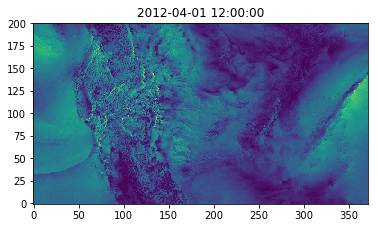

In [15]:
plt.title(str(dt.loc[timestep,"datetime"]))
plt.imshow(data, origin="lower")

In [16]:
%time data = dset[timestep,1100:1400,2000:2400]  # full-resolution subset

CPU times: user 7.97 ms, sys: 4.38 ms, total: 12.4 ms
Wall time: 201 ms


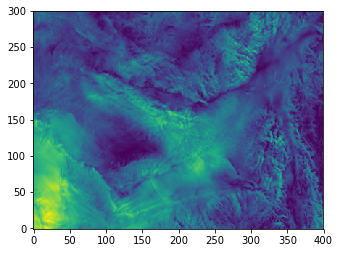

In [17]:
plt.imshow(data, origin="lower")

## Nearest Timeseries for given Lat/Lon

In [18]:
# This function finds the nearest x/y indices for a given lat/lon.
# Rather than fetching the entire coordinates database, which is 500+ MB, this
# uses the Proj4 library to find a nearby point and then converts to x/y indices
def indicesForCoord(f, lat_index, lon_index):
    dset_coords = f['coordinates']
    projstring = """+proj=lcc +lat_1=30 +lat_2=60 
                    +lat_0=38.47240422490422 +lon_0=-96.0 
                    +x_0=0 +y_0=0 +ellps=sphere 
                    +units=m +no_defs """
    projectLcc = Proj(projstring)
    origin_ll = reversed(dset_coords[0][0])  # Grab origin directly from database
    origin = projectLcc(*origin_ll)
    
    coords = (lon_index,lat_index)
    coords = projectLcc(*coords)
    delta = np.subtract(coords, origin)
    ij = [int(round(x/2000)) for x in delta]
    return tuple(reversed(ij))

NewYorkCity = (40.7128, -74.0059)
NewYorkCity_idx = indicesForCoord( f, NewYorkCity[0], NewYorkCity[1] )

print("y,x indices for New York City: \t\t {}".format(NewYorkCity_idx))
print("Coordinates of New York City: \t {}".format(NewYorkCity))
print("Coordinates of nearest point: \t {}".format(f["coordinates"][NewYorkCity_idx[0]][NewYorkCity_idx[1]]))

y,x indices for New York City: 		 (1044, 2375)
Coordinates of New York City: 	 (40.7128, -74.0059)
Coordinates of nearest point: 	 ( 40.709702, -73.992798)


In [19]:
# Get the entire 2010 timeseries data for a point in NYC
%time tseries = dset[min(twentyten):max(twentyten)+1, NewYorkCity_idx[0], NewYorkCity_idx[1]]

CPU times: user 6.35 ms, sys: 2.77 ms, total: 9.11 ms
Wall time: 7.02 s


In [20]:
len(tseries)   # 1 years * 365 days * 24 hours 

8760

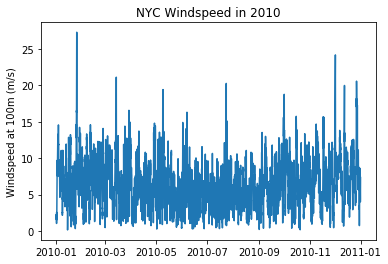

In [21]:
plt.plot(dt.iloc[twentyten,].datetime, tseries)
plt.ylabel("Windspeed at 100m (m/s)")
plt.title("NYC Windspeed in 2010")

In [22]:
# Fetch full timeseries data for all seven years
LongsPeak_idx = indicesForCoord(f, 40.2549, -105.6160)
%time tseries = dset[:,LongsPeak_idx[0],LongsPeak_idx[1]]

CPU times: user 26.4 ms, sys: 6.17 ms, total: 32.6 ms
Wall time: 54.6 s


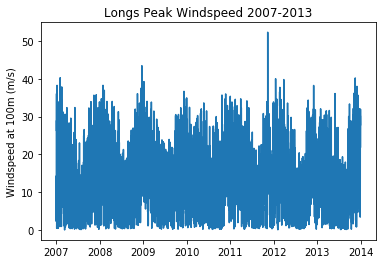

In [23]:
plt.plot(dt.datetime, tseries)
plt.ylabel("Windspeed at 100m (m/s)")
plt.title("Longs Peak Windspeed 2007-2013")

## Windspeed Statistics

In [24]:
dt["windspeed"] = tseries
dt["year"] = dt["datetime"].apply(lambda x: x.year)
dt["month"] = dt["datetime"].apply(lambda x: x.month)
dt["day"] = dt["datetime"].apply(lambda x: x.day)
dt["hour"] = dt["datetime"].apply(lambda x: x.hour)

In [25]:
agg = dt.groupby(["month","hour"]).mean()
agg = agg.reset_index().pivot(index="month",columns="hour",values="windspeed")
agg

hour,0,1,2,3,4,5,6,7,8,9,...,14,15,16,17,18,19,20,21,22,23
month,,,,,,,,,,,,,,,,,,,,,
1,17.782742,17.781574,17.936460,17.981829,17.954967,18.106070,18.217442,18.367193,18.447174,18.534664,...,18.363831,18.178539,17.854143,17.431709,17.194565,17.027246,16.904301,16.998867,17.139912,17.422821
2,16.437485,16.639477,16.689278,16.629135,16.662443,16.965656,17.273306,17.460009,17.616871,17.667582,...,17.730576,17.413107,17.092430,16.651268,16.390566,16.220219,16.195864,16.077782,16.211063,16.287605
3,14.604921,15.130107,15.412607,15.489409,15.776677,16.043848,16.277828,16.474186,16.677057,16.629452,...,16.498095,16.084057,15.284851,14.944521,14.798256,14.730160,14.745756,14.960455,14.894045,14.823627
4,13.538098,13.942963,14.095672,14.382008,14.624935,14.589562,14.894791,15.148313,15.371621,15.806626,...,15.633238,14.803759,14.014667,13.467426,13.230791,13.364985,13.376946,13.591709,13.539725,13.335716
5,11.307108,11.303395,11.524436,11.436130,11.292299,11.719445,11.939952,11.890996,12.257992,12.596297,...,12.245151,11.770721,11.352464,11.030233,11.190969,11.271287,11.059191,11.392616,11.504339,11.454047
6,12.146861,11.924526,11.722508,11.499505,11.589317,11.590261,11.332961,11.392022,11.676019,12.099078,...,11.952153,11.572066,11.499331,11.411350,11.469437,11.594026,11.791553,12.379775,12.270243,12.375328
7,7.504178,7.493124,7.438205,7.311883,7.368392,7.312094,7.841232,7.848489,7.851456,8.082863,...,8.146431,7.786299,7.660076,7.651398,7.561840,7.867813,8.126966,8.486354,7.907937,7.684139
8,8.010785,8.004921,7.972166,7.861540,7.758930,8.114224,8.464076,8.491234,8.781244,9.044336,...,9.444621,9.003101,8.690378,8.655358,8.424558,8.409269,8.399918,8.803268,8.915976,8.636556
9,9.860007,9.619100,9.669471,10.028005,10.206232,10.343493,10.769067,11.195759,11.499839,11.649380,...,11.362492,10.789354,10.624351,10.473779,10.323612,10.251211,10.327231,10.510371,10.489648,10.150558


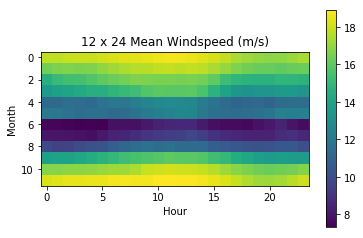

In [26]:
plt.imshow(agg)
plt.xlabel("Hour")
plt.ylabel("Month")
plt.title("12 x 24 Mean Windspeed (m/s)")
plt.colorbar()